In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import itertools
import math
import numpy as np
import pandas as pd
import re
import string
import spacy
import tensorflow as tf


# Train & Test Dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score

# Library for Text Processing and Natural Language Toolkit (NLTK)
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

# Library for Represent the frequent text in visual.
from wordcloud import WordCloud,STOPWORDS





# Warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **DATA PREPROCESSING**

In [ ]:
drug = pd.read_csv('webmd.csv')

In [ ]:
drug.tail()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
362801,55-64,Stop Smoking,11/14/2008,chantix,144470,5,5,I took the whole 12 weeks.I could have stopped...,5,Female,"Nausea , headache , vomiting , drowsiness, g...",2
362802,,Other,11/14/2008,chantix,144470,2,3,My dad strated taking Chantix about 1 month ag...,1,,"Nausea , headache , vomiting , drowsiness, g...",16
362803,25-34,Stop Smoking,11/13/2008,chantix,144470,2,4,"As long as I was on chantix, I didn't smoke. ...",2,Female,"Nausea , headache , vomiting , drowsiness, g...",3
362804,55-64,Stop Smoking,11/13/2008,chantix,144470,5,5,Started this medication Oct 5th 2008. Haven't ...,5,Male,"Nausea , headache , vomiting , drowsiness, g...",1
362805,45-54,Stop Smoking,11/12/2008,chantix,144470,4,5,"One year ago, I tried Chantix and had to stop ...",5,Female,"Nausea , headache , vomiting , drowsiness, g...",3


In [ ]:
drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


In [ ]:
drug.describe()

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,362806.000000,362806.000000,362806.000000,362806.000000,362806.000000
mean,36879.370774,4.019829,3.532061,3.135408,6.744916
std,52624.412971,1.317711,1.455961,1.611106,9.324240
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4896.000000,3.000000,3.000000,1.000000,1.000000
50%,9548.000000,5.000000,4.000000,3.000000,4.000000
75%,63522.000000,5.000000,5.000000,5.000000,9.000000
max,178546.000000,10.000000,10.000000,10.000000,255.000000


Useful count min 0? This make no sense

## **DATA CLEANING**

In [ ]:
df = drug [['Age', 'Condition', 'Drug', 'DrugId', 'EaseofUse',
            'Effectiveness', 'Satisfaction', 'Sex', 'Reviews', 'UsefulCount',
            'Sides', 'Date']]

In [ ]:
for col in df.columns:
    if df[col].dtype.kind == "O":
        df[col] = df[col].str.strip()

In [ ]:
data = [[col, df[col].nunique()] for col in df.columns.difference(["Reviews"])]
uniques = pd.DataFrame(data=data, columns=["columns", "num of unique values"])

In [ ]:
uniques

,columns,num of unique values
0,Age,12
1,Condition,1806
2,Date,4524
3,Drug,7093
4,DrugId,6572
5,EaseofUse,7
6,Effectiveness,7
7,Satisfaction,7
8,Sex,3
9,Sides,1650


- Sex unique values are 3? This make no sense, since we know theres only 2 type of sex, female and male.
- Drug has more values than DrugId?
- Ease of Use, Effectiveness, Satisfaction have numbers that are ambiguous or not in the correct order. While the rating used is only up to 5

### **Missing Values**

In [ ]:
def missing_values(df):

    """Returns a summary of missing values in df"""
    nrows = df.shape[0]
    data = []

    def pct(n, total):
        return round(n/total, 2)

    for col in df.columns:

        # string (Object) type columns
        if df[col].dtype.kind == "O":
            df[col] = df[col].str.strip()
            nulls = df[df[col] == ""][col].count()
            nulls += df[col].isnull().sum()

            # numerical (int) type columns
        elif df[col].dtype.kind == "i":
            nulls = df[col].isnull().sum()

        pctofnulls = pct(nulls, nrows)
        data.extend(
            [{"column": col, "pct": 1-pctofnulls, "num of records": nrows-nulls,
              "type": "not missing"},
             {"column": col, "pct": pctofnulls, "num of records": nulls,
              "type": "missing"}])

    return pd.DataFrame(data)

missing = missing_values(df)

bars = (alt.Chart()
           .mark_bar(size=25,
                     strokeWidth=1,
                     stroke="white",
                     strokeOpacity=0.7,
                     )
           .encode(x=alt.X("sum(num of records)",
                           axis=alt.Axis(title="number of records",
                                         grid=True)),
                   y=alt.Y("column:O",
                           axis=alt.Axis(title="columns")),
                   tooltip=("column", "type", "num of records:Q",
                            alt.Tooltip("pct:Q", format=".1%")),
                   color=alt.Color("type",
                                   scale=alt.Scale(range=["#11043a",
                                                          "#648bce"])))
           .properties(title="Missing Values"))

text = (alt.Chart()
           .mark_text(align="right",
                      dx=-1)
           .encode(x=alt.X("sum(num of records)",
                           stack="zero"),
                   y=alt.Y("column"),
                   color=alt.Color("type",
                                   legend=None,
                                   scale=alt.Scale(range=["white"])),
                   text=alt.Text("pct", format=".0%")))

(alt.layer(bars, text, data = missing)
    .configure(background='#11043a')
    .configure_title(font="Arial",
                     fontSize=18,
                     color="#e6f3ff",
                     dy=-10)
    .configure_text(color="white")
    .configure_legend(titleFontSize=12,
                      titleColor="white",
                      tickCount=10,
                      titleOpacity=0.8,
                      labelColor="white",
                      labelOpacity=0.7,
                      titlePadding=10)
.configure_axis(titleFontSize=13,
                    titlePadding=20,
                    titleColor="white",
                    titleOpacity=0.8,
                    labelFontSize=11,
                    labelColor="white",
                    labelOpacity=0.7,
                    tickOffset=0,
                    grid=False,
                    gridOpacity=0.15)
    .configure_view(strokeWidth=0)
    .resolve_scale(color='independent')
    .properties(height=300, width=680))

alt.LayerChart(...)

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

Age              0
Condition        0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Satisfaction     0
Sex              0
Reviews          0
UsefulCount      0
Sides            0
Date             0
dtype: int64

**The chart above reveals about 12% new missing values in Reviews, 7% in Sex, 5% in Sides and 3% in Age. Since the missing values are relatively small we can simply drop them (simple, yet the best option)**

### **Duplicates**

In [ ]:
df.duplicated().sum()

944

**There are duplicated values in dataset rows and will be dropped later**

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

**Duplicated rows have gone!**

### **Checking Each Column Values**

In [ ]:
print(df["Satisfaction"].value_counts())


5     111163
1     100697
4      63031
3      51784
2      35147
6          2
10         1
Name: Satisfaction, dtype: int64


In [ ]:
df = df[df['Satisfaction'] <= 5]

In [ ]:
print(df["Satisfaction"].value_counts())

5    111163
1    100697
4     63031
3     51784
2     35147
Name: Satisfaction, dtype: int64


In [ ]:
print(df["Effectiveness"].value_counts())

5    130022
4     81660
3     60185
1     59251
2     30704
Name: Effectiveness, dtype: int64


In [ ]:
print(df["EaseofUse"].value_counts())

5    192211
4     74395
3     41166
1     35874
2     18176
Name: EaseofUse, dtype: int64


In [ ]:
print(df["Sex"].value_counts())

Female    237732
Male       97657
           26433
Name: Sex, dtype: int64


In [ ]:
for col in ["Age", "Sex", "Reviews", "UsefulCount", "Condition","Sides"]:
    df = df[(df[col].astype(bool) & df[col].notnull())]

In [ ]:
print(df["Sex"].value_counts())

Female    172325
Male       64724
Name: Sex, dtype: int64


In [ ]:
print(df["Age"].value_counts())

45-54         55367
55-64         48746
35-44         39213
25-34         36467
65-74         24625
19-24         17627
75 or over     8434
13-18          4683
7-12           1130
3-6             501
0-2             256
Name: Age, dtype: int64


In [ ]:
print(df["UsefulCount"].value_counts())

1      32307
2      26156
3      21871
4      18938
5      16587
       ...  
135        1
126        1
255        1
154        1
95         1
Name: UsefulCount, Length: 143, dtype: int64


In [ ]:
print(df["Sides"].value_counts())

Nausea ,  vomiting ,  constipation ,  lightheadedness ,  dizziness , or drowsiness may occur.                                                                                                  9071
Nausea ,  vomiting ,  headache ,  bloating ,  breast  tenderness, swelling of the  ankles /feet (fluid retention), or  weight  change may occur.                                               7255
Dizziness ,  lightheadedness , tiredness, or  headache  may occur as your body adjusts to the  medication . Dry  cough  may also occur.                                                        6662
Drowsiness,  dizziness , loss of coordination, tiredness, blurred/ double vision , unusual  eye  movements, or shaking (tremor) may occur.                                                     5874
Nausea ,  vomiting ,  stomach  upset,  diarrhea ,  weakness , or a  metallic taste  in the  mouth  may occur.                                                                                  3894
                    

### **Statistical Summary**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237049 entries, 1 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            237049 non-null  object
 1   Condition      237049 non-null  object
 2   Drug           237049 non-null  object
 3   DrugId         237049 non-null  int64 
 4   EaseofUse      237049 non-null  int64 
 5   Effectiveness  237049 non-null  int64 
 6   Satisfaction   237049 non-null  int64 
 7   Sex            237049 non-null  object
 8   Reviews        237049 non-null  object
 9   UsefulCount    237049 non-null  int64 
 10  Sides          237049 non-null  object
 11  Date           237049 non-null  object
dtypes: int64(5), object(7)
memory usage: 23.5+ MB


In [ ]:
numericals = ['EaseofUse', 'Effectiveness', 'Satisfaction', 'UsefulCount']

In [ ]:
df[numericals].describe()

,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,237049.000000,237049.000000,237049.000000,237049.000000
mean,4.065472,3.570688,3.124371,8.707672
std,1.298183,1.458688,1.624834,9.688730
min,1.000000,1.000000,1.000000,1.000000
25%,4.000000,3.000000,1.000000,3.000000
50%,5.000000,4.000000,3.000000,6.000000
75%,5.000000,5.000000,5.000000,11.000000
max,5.000000,5.000000,5.000000,255.000000


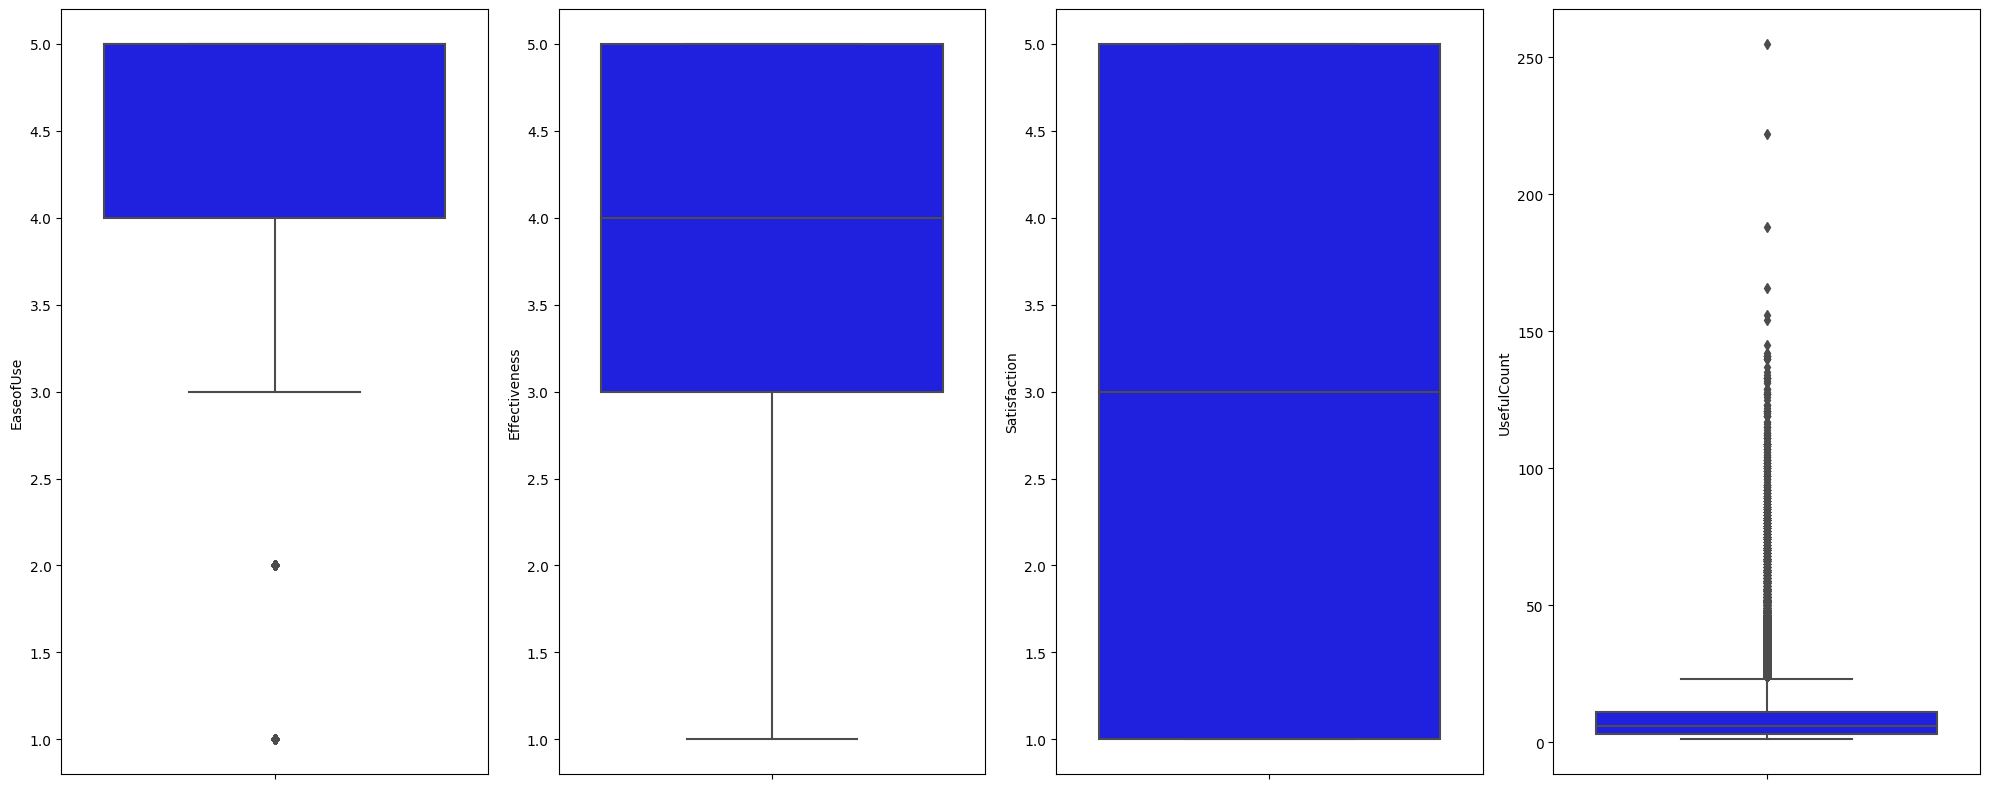

In [ ]:
#outlier checking

plt.figure(figsize=(20,8))

feat_num = list(df[numericals])
for i in range(0, len(feat_num)):
    plt.subplot(1, len(feat_num), i+1)
    sns.boxplot(y=df[feat_num[i]],color='blue', orient='v')
    plt.tight_layout()

In [ ]:
len(df[df['UsefulCount'] > 25])


13177

In [ ]:
dfc = df.copy()

In [ ]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237049 entries, 1 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            237049 non-null  object
 1   Condition      237049 non-null  object
 2   Drug           237049 non-null  object
 3   DrugId         237049 non-null  int64 
 4   EaseofUse      237049 non-null  int64 
 5   Effectiveness  237049 non-null  int64 
 6   Satisfaction   237049 non-null  int64 
 7   Sex            237049 non-null  object
 8   Reviews        237049 non-null  object
 9   UsefulCount    237049 non-null  int64 
 10  Sides          237049 non-null  object
 11  Date           237049 non-null  object
dtypes: int64(5), object(7)
memory usage: 23.5+ MB


In [ ]:
len(dfc[dfc['UsefulCount'] >25])

13177

In [ ]:
14565/248354

0.05864612609420424

Because of the outlier is still make sense, we will not remove all Useful count of drug that are more than 25 since it is only 5% from the total data.

In [ ]:
dfc.describe()

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,237049.000000,237049.000000,237049.000000,237049.000000,237049.000000
mean,35615.313252,4.065472,3.570688,3.124371,8.707672
std,51189.075287,1.298183,1.458688,1.624834,9.688730
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4896.000000,4.000000,3.000000,1.000000,3.000000
50%,9690.000000,5.000000,4.000000,3.000000,6.000000
75%,63163.000000,5.000000,5.000000,5.000000,11.000000
max,178485.000000,5.000000,5.000000,5.000000,255.000000


## **FEATURE ENGINEERING**

In [ ]:
dfc.head(5)

,Age,Condition,Drug,DrugId,EaseofUse,Effectiveness,Satisfaction,Sex,Reviews,UsefulCount,Sides,Date
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,5,Female,cleared me right up even with my throat hurtin...,1,"Drowsiness, dizziness , dry mouth /nose/thro...",1/13/2011
16,25-34,Birth Control,lyza,164750,1,1,1,Female,LYZA BIRTH CONTROL\nThese are the WORST birth ...,1,"Nausea , vomiting , headache , bloating , ...",10/7/2017
18,25-34,Birth Control,lyza,164750,5,5,4,Female,I have been taking Lyza for two months now. I ...,1,"Nausea , vomiting , headache , bloating , ...",1/30/2017
19,25-34,Birth Control,lyza,164750,2,5,1,Female,I have been on this pill for a little over two...,3,"Nausea , vomiting , headache , bloating , ...",6/1/2016
21,25-34,Birth Control,lyza,164750,5,5,4,Female,My OB/GYN placed me on this pill because I was...,10,"Nausea , vomiting , headache , bloating , ...",4/29/2016


In [ ]:
dfc['Year'] = pd.to_datetime(dfc['Date'], errors='coerce').dt.year
dfc['Month'] = pd.to_datetime(dfc['Date'], errors='coerce').dt.month
dfc['day_of_week'] = pd.to_datetime(dfc['Date'], errors='coerce').dt.day_name()

In [ ]:
dfc.head(5)

,Age,Condition,Drug,DrugId,EaseofUse,Effectiveness,Satisfaction,Sex,Reviews,UsefulCount,Sides,Date,Year,Month,day_of_week
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,5,Female,cleared me right up even with my throat hurtin...,1,"Drowsiness, dizziness , dry mouth /nose/thro...",1/13/2011,2011,1,Thursday
16,25-34,Birth Control,lyza,164750,1,1,1,Female,LYZA BIRTH CONTROL\nThese are the WORST birth ...,1,"Nausea , vomiting , headache , bloating , ...",10/7/2017,2017,10,Saturday
18,25-34,Birth Control,lyza,164750,5,5,4,Female,I have been taking Lyza for two months now. I ...,1,"Nausea , vomiting , headache , bloating , ...",1/30/2017,2017,1,Monday
19,25-34,Birth Control,lyza,164750,2,5,1,Female,I have been on this pill for a little over two...,3,"Nausea , vomiting , headache , bloating , ...",6/1/2016,2016,6,Wednesday
21,25-34,Birth Control,lyza,164750,5,5,4,Female,My OB/GYN placed me on this pill because I was...,10,"Nausea , vomiting , headache , bloating , ...",4/29/2016,2016,4,Friday


## Drug vs DrugId

In [ ]:
drugs = {}
for drugid, drug in df[["DrugId", "Drug"]].itertuples(index=False):
    drugs.setdefault(drugid, set()).add(drug)
drugs = {k:list(v) for k,v in drugs.items()}

drugs_with_more_names = {k:list(v) for k,v in drugs.items() if len(v) > 1}
for k,v in dict(itertools.islice(drugs_with_more_names.items(), 10)).items():
    print(f"{k:10}: {list(v)[:2]}")

    167493: ['lynparza tablet', 'lynparza']
      7286: ['loteprednol etabonate drops, suspension', 'loteprednol etabonate ointment']
      7319: ['lotemax drops, gel', 'lotemax ointment']
    164437: ['lorcaserin tablet, extended release 24 hr', 'lorcaserin tablet']
      8892: ['lorazepam', 'lorazepam concentrate']
     76548: ['loratadine d', 'loratadine-d']
        73: ['loratadine tablet,disintegrating', 'loratadine']
      8555: ['loprox cream', 'loprox suspension, topical']
      4789: ['loperamide liquid', 'loperamide']
      5887: ['lithium carbonate er', 'lithium carbonate']


**The reason why Drug has more values than DrugId is that some drugs are sold is different forms, like loprox cream, lorazepam, gel, etc**

In [ ]:
dfc = dfc.drop(columns=['DrugId'])

In [ ]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237049 entries, 1 to 362805
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            237049 non-null  object
 1   Condition      237049 non-null  object
 2   Drug           237049 non-null  object
 3   EaseofUse      237049 non-null  int64 
 4   Effectiveness  237049 non-null  int64 
 5   Satisfaction   237049 non-null  int64 
 6   Sex            237049 non-null  object
 7   Reviews        237049 non-null  object
 8   UsefulCount    237049 non-null  int64 
 9   Sides          237049 non-null  object
 10  Date           237049 non-null  object
 11  Year           237049 non-null  int64 
 12  Month          237049 non-null  int64 
 13  day_of_week    237049 non-null  object
dtypes: int64(6), object(8)
memory usage: 27.1+ MB


So we will only use Drug column instead of DrugID

# **EXPLORATORY DATA ANALYSIS**

## Most common conditions among the patients

In [ ]:
pip install wordcloud

Text(0, 0.5, 'Users')

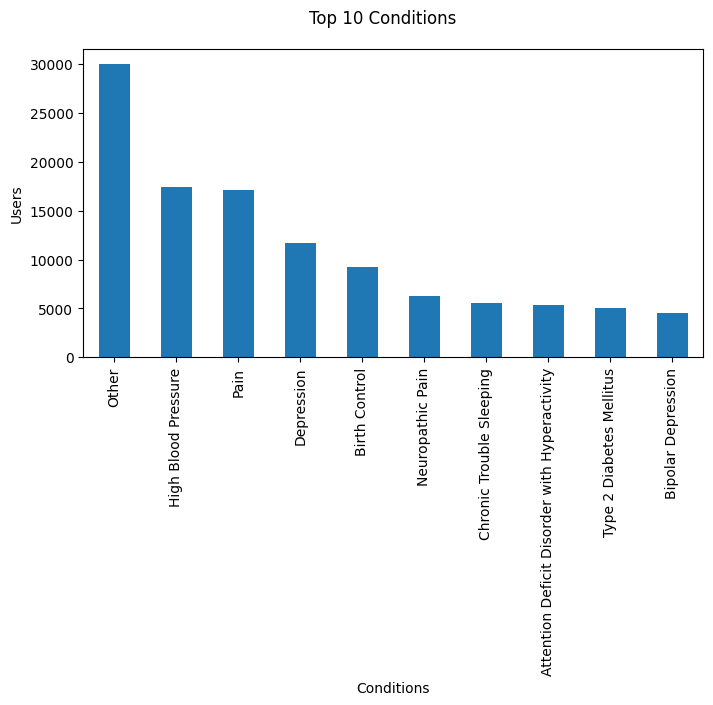

In [ ]:
dfc['Condition'].value_counts().nlargest(10).plot(kind='bar',figsize=(8,4))
plt.suptitle("Top 10 Conditions")
plt.xlabel('Conditions')
plt.ylabel('Users')

### Let's find out more about High Blood Pressure

In [ ]:
blood = dfc[dfc['Condition'].str.contains('High Blood Pressure', case=False, na=False)]

blood.head(10)

,Age,Condition,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,Reviews,UsefulCount,Sides,Date,Year,Month,day_of_week
3939,45-54,High Blood Pressure,lotrel,1,1,1,Female,This medication caused my blood pressure to el...,7,Dizziness or light-headedness may occur as yo...,11/25/2014,2014,11,Tuesday
3958,55-64,High Blood Pressure,lotrel,3,3,1,Female,I was on this medication for 2 weeks. Had side...,6,Dizziness or light-headedness may occur as yo...,6/25/2014,2014,6,Wednesday
3967,55-64,High Blood Pressure,lotrel,4,4,1,Female,I have a scratchy throat that makes me cough a...,8,Dizziness or light-headedness may occur as yo...,5/19/2014,2014,5,Monday
3977,65-74,High Blood Pressure,lotrel,5,5,5,Male,"Since starting Lotrel, my lab work is showing ...",5,Dizziness or light-headedness may occur as yo...,1/24/2014,2014,1,Friday
3988,65-74,High Blood Pressure,lotrel,4,4,3,Male,Very iritated w/the dry caugh which seems to b...,3,Dizziness or light-headedness may occur as yo...,1/10/2014,2014,1,Friday
3998,35-44,High Blood Pressure,lotrel,2,3,1,Male,"This drug has lowered my b/p, but I have notic...",5,Dizziness or light-headedness may occur as yo...,10/20/2013,2013,10,Sunday
4027,45-54,High Blood Pressure,lotrel,5,5,5,Female,This is the only drug that has worked on my hi...,3,Dizziness or light-headedness may occur as yo...,3/12/2013,2013,3,Tuesday
4032,55-64,High Blood Pressure,lotrel,4,4,3,Male,Has controlled BP but is affecting my kidney f...,3,Dizziness or light-headedness may occur as yo...,3/8/2013,2013,3,Friday
4049,55-64,High Blood Pressure,lotrel,5,3,3,Male,I've been on the generic Lotrel for about 5 ye...,2,Dizziness or light-headedness may occur as yo...,11/24/2012,2012,11,Saturday
4062,55-64,High Blood Pressure,lotrel,4,4,4,Male,I have had some cases of dizziness,2,Dizziness or light-headedness may occur as yo...,12/29/2010,2010,12,Wednesday


Text(0, 0.5, 'Users')

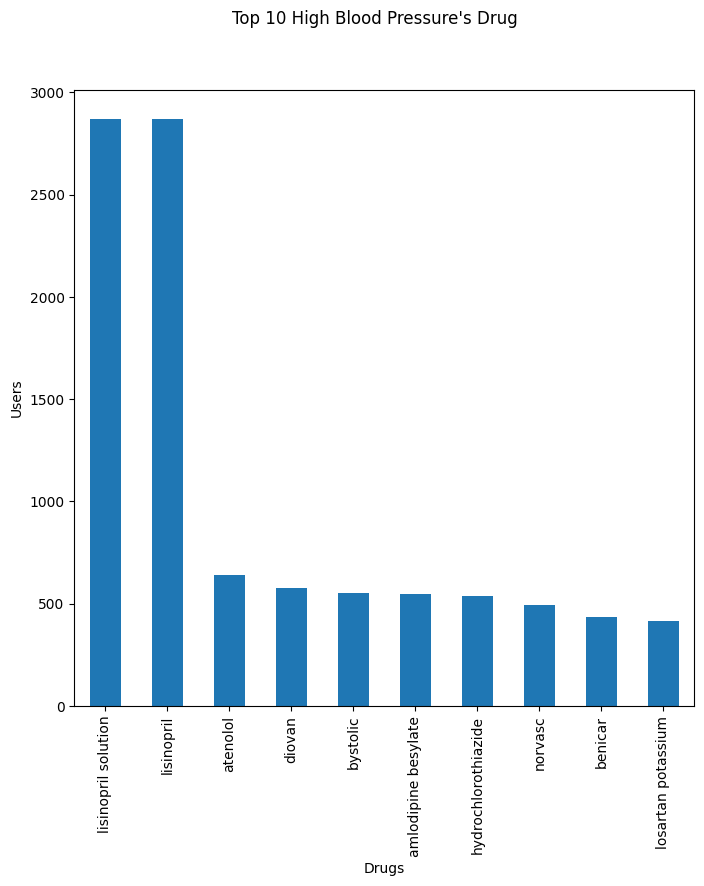

In [ ]:
blood['Drug'].value_counts().nlargest(10).plot(kind='bar',figsize=(8,8))
plt.suptitle("Top 10 High Blood Pressure's Drug")
plt.xlabel('Drugs')
plt.ylabel('Users')

#### High Blood Pressure by Year

Text(0, 0.5, 'Patient')

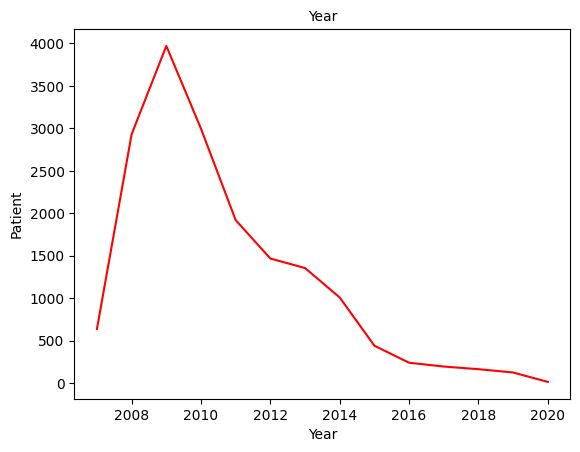

In [ ]:
blood['Year'].value_counts().sort_index().plot(kind='line', color='red')
plt.title("Year", fontsize = 10)
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Patient", fontsize = 10)

#### High Blood Pressure by Age

<Figure size 700x600 with 0 Axes>

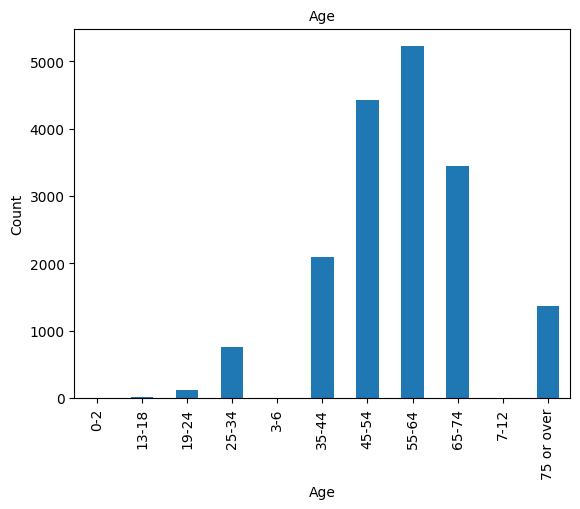

<Figure size 700x600 with 0 Axes>

In [ ]:
blood['Age'].value_counts().sort_index().plot(kind='bar')
plt.title("Age", fontsize = 10)
plt.xlabel("Age", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.figure(figsize=(7,6))

#### High Blood Pressure by Gender

<Figure size 700x600 with 0 Axes>

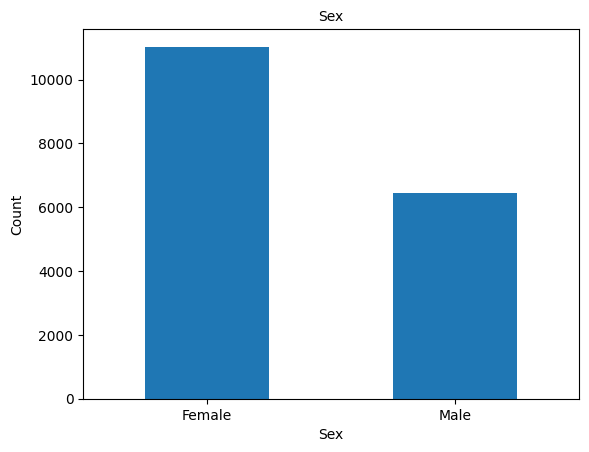

<Figure size 700x600 with 0 Axes>

In [ ]:
blood['Sex'].value_counts().plot(kind='bar')
plt.title("Sex", fontsize = 10)
plt.xlabel("Sex", fontsize = 10)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize = 10)
plt.figure(figsize=(7,6))

#### High Blood Pressure by Gender and Age

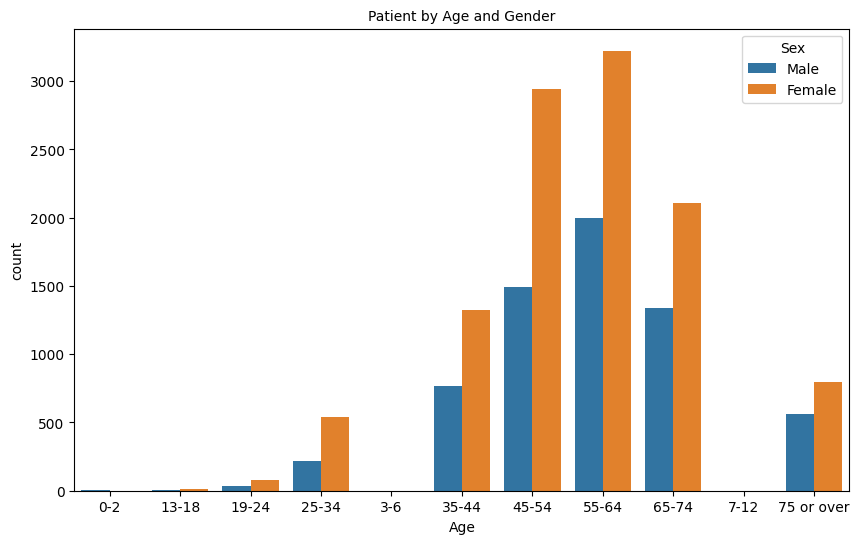

In [ ]:

blood_sorted = blood.sort_values(by='Age')
plt.figure(figsize=(10, 6))
sns.countplot(x='Age', hue='Sex', data=blood_sorted)
plt.title("Patient by Age and Gender", fontsize=10)

plt.show()


## Most popular drug among high blood pressure patients


Text(0, 0.5, 'Users')

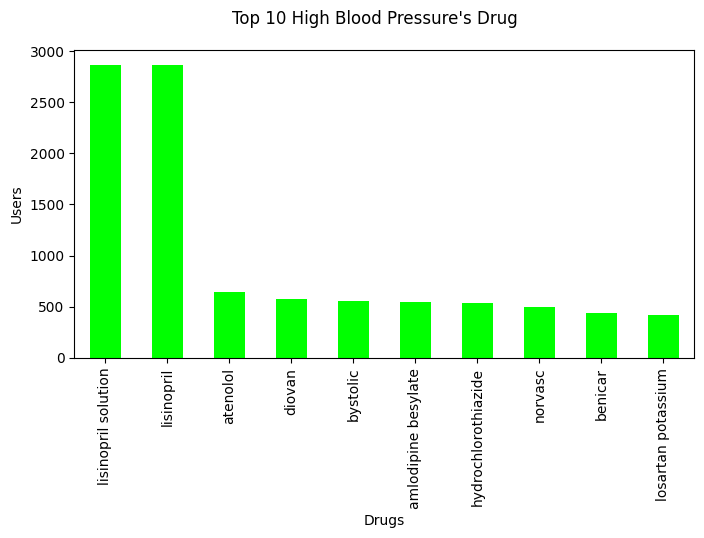

In [ ]:
blood['Drug'].value_counts().nlargest(10).plot(kind='bar',
                                               figsize=(8,4),
                                               color='lime')
plt.suptitle("Top 10 High Blood Pressure's Drug")
plt.xlabel('Drugs')
plt.ylabel('Users')

Text(0, 0.5, 'Users')

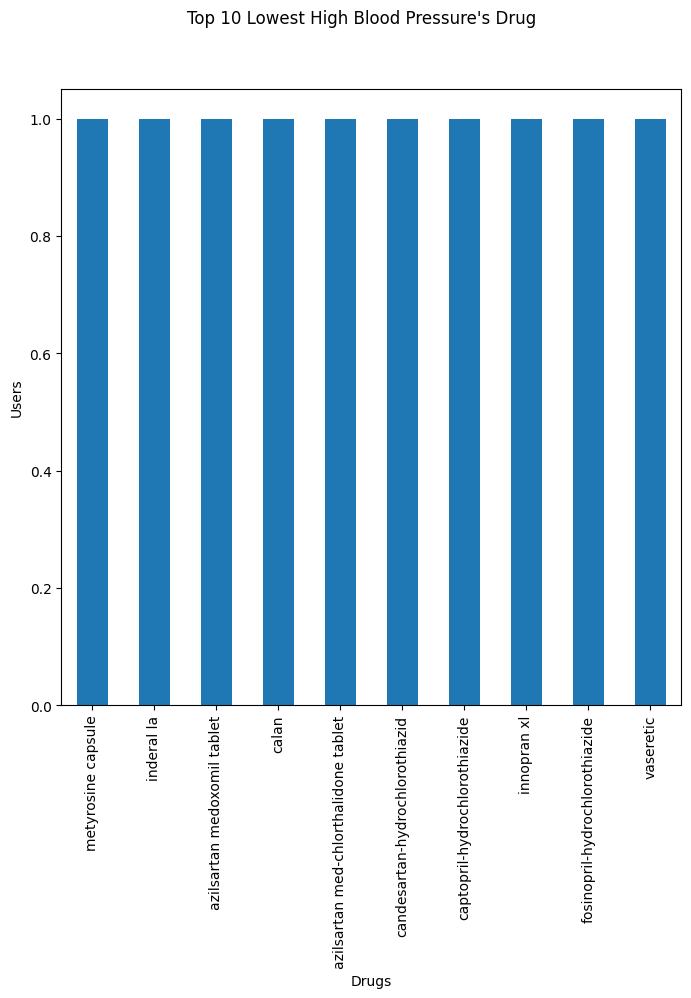

In [ ]:
blood['Drug'].value_counts().nsmallest(10).plot(kind='bar',figsize=(8,8))
plt.suptitle("Top 10 Lowest High Blood Pressure's Drug")
plt.xlabel('Drugs')
plt.ylabel('Users')

In [ ]:
lisi = dfc[dfc['Drug'].str.contains('lisinopril', case=False, na=False)]

lisi.head(10)

,Age,Condition,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,Reviews,UsefulCount,Sides,Date,Year,Month,day_of_week
9088,65-74,High Blood Pressure,lisinopril-hydrochlorothiazide,4,4,2,Male,Took this for about four years. I had the coug...,2,"Dizziness , lightheadedness , tiredness, or ...",8/20/2019,2019,8,Tuesday
9101,45-54,High Blood Pressure,lisinopril-hydrochlorothiazide,5,5,5,Female,I have been taking this for HBP for around 3 m...,2,"Dizziness , lightheadedness , tiredness, or ...",5/12/2019,2019,5,Sunday
9147,55-64,High Blood Pressure,lisinopril-hydrochlorothiazide,1,1,1,Female,Broke with blisters all over my face,1,"Dizziness , lightheadedness , tiredness, or ...",10/20/2018,2018,10,Saturday
9157,35-44,High Blood Pressure,lisinopril-hydrochlorothiazide,5,1,1,Female,Day 1 severe stomach pain and diarrhea . Day 2...,1,"Dizziness , lightheadedness , tiredness, or ...",4/25/2018,2018,4,Wednesday
9162,55-64,High Blood Pressure,lisinopril-hydrochlorothiazide,5,1,1,Female,"In less than a month, I've developed a horribl...",8,"Dizziness , lightheadedness , tiredness, or ...",4/18/2018,2018,4,Wednesday
9187,45-54,High Blood Pressure,lisinopril-hydrochlorothiazide,4,4,1,Female,been on this for nearly 10 yrs..cannot go out ...,11,"Dizziness , lightheadedness , tiredness, or ...",10/13/2017,2017,10,Friday
9192,45-54,High Blood Pressure,lisinopril-hydrochlorothiazide,5,3,1,Male,"On lisinopril 6 mths, coughing (bad) 5 months ...",3,"Dizziness , lightheadedness , tiredness, or ...",9/19/2017,2017,9,Tuesday
9198,55-64,High Blood Pressure,lisinopril-hydrochlorothiazide,1,1,1,Male,do not take this drug i was on it for 1.5 yrs ...,9,"Dizziness , lightheadedness , tiredness, or ...",7/15/2017,2017,7,Saturday
9203,75 or over,High Blood Pressure,lisinopril solution,5,4,4,Female,I have developed a very itch rash on my body f...,3,"Dizziness , lightheadedness , tiredness, or ...",2/8/2020,2020,2,Saturday
9209,55-64,High Blood Pressure,lisinopril solution,4,5,4,Male,"tried alternative medicine Beet root, hibiscus...",3,"Dizziness , lightheadedness , tiredness, or ...",1/14/2020,2020,1,Tuesday


### Let's find out more about lisinopril

<Figure size 700x600 with 0 Axes>

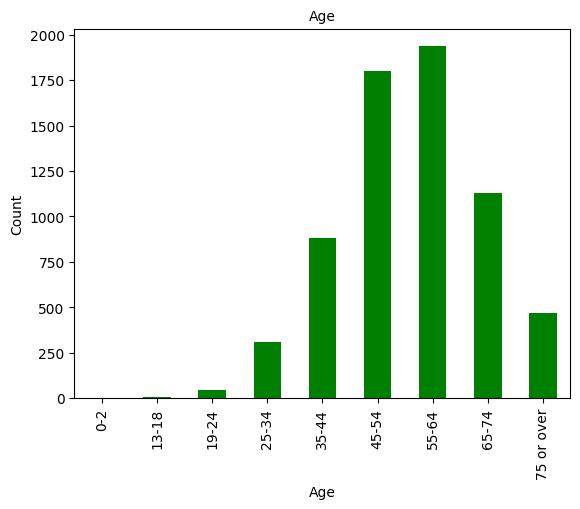

<Figure size 700x600 with 0 Axes>

In [ ]:
lisi['Age'].value_counts().sort_index().plot(kind='bar', color='green')
plt.title("Age", fontsize = 10)
plt.xlabel("Age", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.figure(figsize=(7,6))

#### Lisinopril effectiveness among the age category

<Axes: xlabel='Age', ylabel='count'>

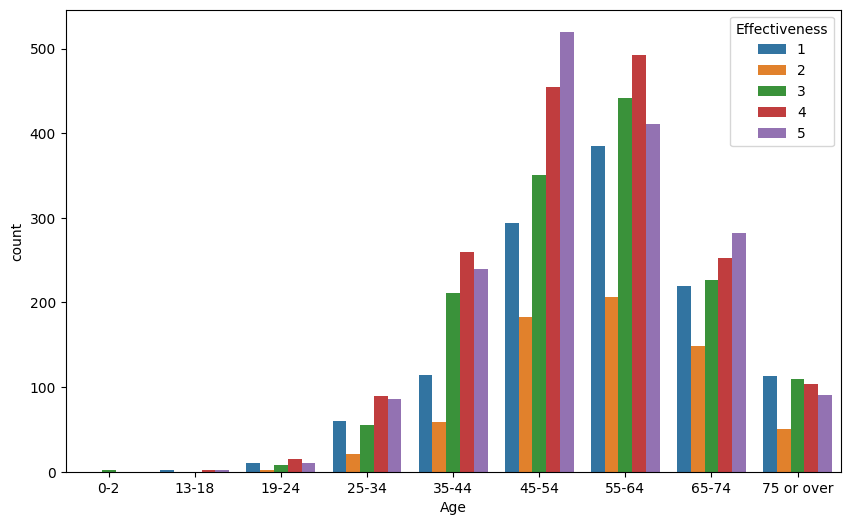

In [ ]:
lisi_sorted = lisi.sort_values(by='Age')
plt.figure(figsize=(10, 6))
sns.countplot(x='Age',hue='Effectiveness',data=lisi_sorted)

#### Lisinopril effectiveness among the sex category

<Axes: xlabel='Sex', ylabel='count'>

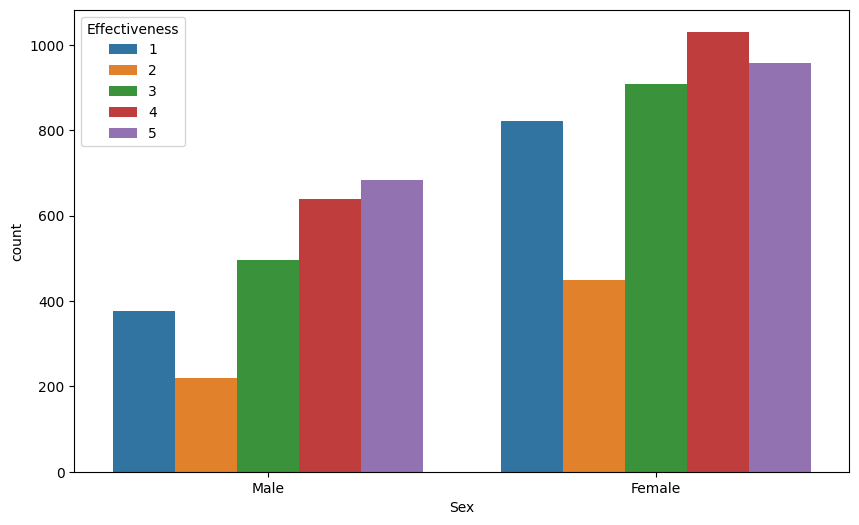

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex',hue='Effectiveness',data=lisi)

#### Reviews about lisinopril

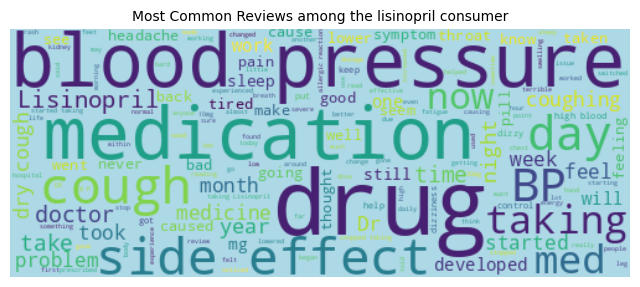

In [ ]:
from wordcloud import WordCloud, STOPWORDS

all_text_review = ' '.join(lisi['Reviews'])

wc_text_review = WordCloud(width = 500,
               height = 200,
               stopwords = STOPWORDS,
               background_color = 'lightblue',
               random_state = 42).generate(all_text_review)

plt.figure(figsize = (8,5))
plt.title('Most Common Reviews among the lisinopril consumer', fontsize = 10)
plt.imshow(wc_text_review, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Lisinopril Sides Effect

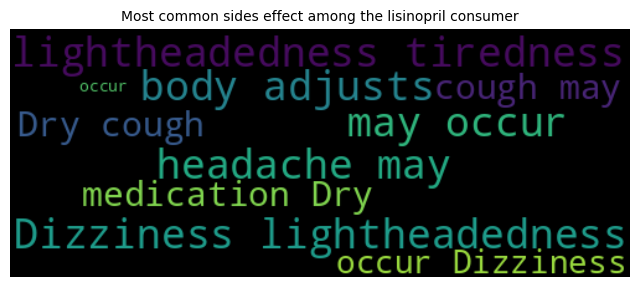

In [ ]:
from wordcloud import WordCloud, STOPWORDS

all_text_review = ' '.join(lisi['Sides'])

wc_text_review = WordCloud(width = 500,
               height = 200,
               stopwords = STOPWORDS,
               background_color = 'black',
               random_state = 42).generate(all_text_review)

plt.figure(figsize = (8,5))
plt.title('Most common sides effect among the lisinopril consumer',
          fontsize = 10)
plt.imshow(wc_text_review, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Lisinopril consumer by year

Text(0, 0.5, 'Consumer')

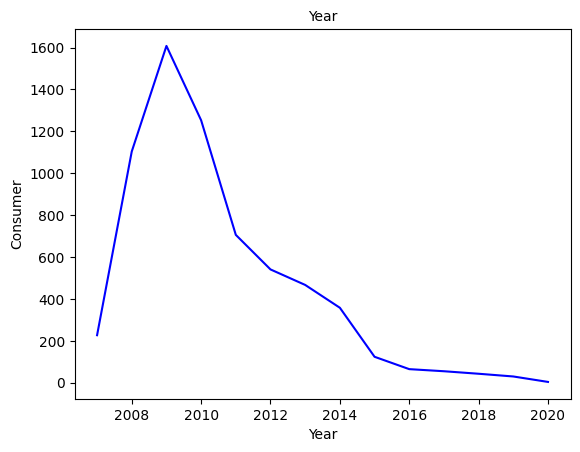

In [ ]:
lisi['Year'].value_counts().sort_index().plot(kind='line', color='blue')
plt.title("Year", fontsize = 10)
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Consumer", fontsize = 10)

#### Lisinopril Satisfaction Rating

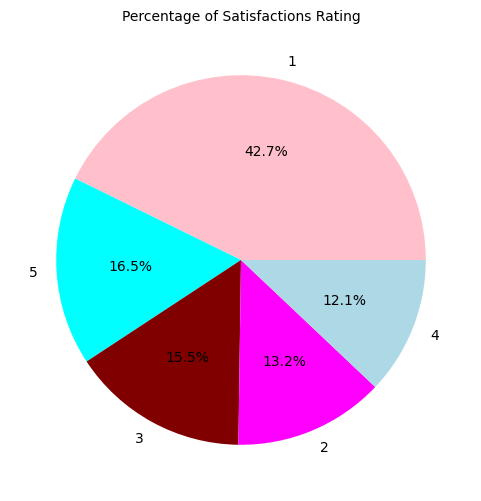

In [ ]:
from typing_extensions import LiteralString
plt.figure(figsize=(6,6))
colors = ['pink', 'cyan', 'maroon',  'magenta', 'lightblue', 'lightgreen']
lisi['Satisfaction'].value_counts().plot.pie(colors = colors,
                                            autopct='%1.1f%%')
plt.axis('off')
plt.title('Percentage of Satisfactions Rating', fontsize = 10)
plt.show()

Lets find more about rating 1 in Lisinopril

In [ ]:
lisrat = lisi[lisi['Satisfaction'] == 1]

In [ ]:
lisrat

,Age,Condition,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,Reviews,UsefulCount,Sides,Date,Year,Month,day_of_week
9147,55-64,High Blood Pressure,lisinopril-hydrochlorothiazide,1,1,1,Female,Broke with blisters all over my face,1,"Dizziness , lightheadedness , tiredness, or ...",10/20/2018,2018,10,Saturday
9157,35-44,High Blood Pressure,lisinopril-hydrochlorothiazide,5,1,1,Female,Day 1 severe stomach pain and diarrhea . Day 2...,1,"Dizziness , lightheadedness , tiredness, or ...",4/25/2018,2018,4,Wednesday
9162,55-64,High Blood Pressure,lisinopril-hydrochlorothiazide,5,1,1,Female,"In less than a month, I've developed a horribl...",8,"Dizziness , lightheadedness , tiredness, or ...",4/18/2018,2018,4,Wednesday
9187,45-54,High Blood Pressure,lisinopril-hydrochlorothiazide,4,4,1,Female,been on this for nearly 10 yrs..cannot go out ...,11,"Dizziness , lightheadedness , tiredness, or ...",10/13/2017,2017,10,Friday
9192,45-54,High Blood Pressure,lisinopril-hydrochlorothiazide,5,3,1,Male,"On lisinopril 6 mths, coughing (bad) 5 months ...",3,"Dizziness , lightheadedness , tiredness, or ...",9/19/2017,2017,9,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18979,19-24,High Blood Pressure,lisinopril,2,2,1,Female,I HAVE BEEN TAKING THIS MEDICATION FOR A LIL O...,19,"Dizziness , lightheadedness , tiredness, or ...",5/13/2008,2008,5,Tuesday
18981,25-34,Kidney Disease from Diabetes,lisinopril,2,1,1,Female,I was prescribed this medication to prevent ki...,18,"Dizziness , lightheadedness , tiredness, or ...",5/11/2008,2008,5,Sunday
18982,45-54,High Blood Pressure,lisinopril,5,1,1,Male,I am a 51 year old male with type II diabetes....,12,"Dizziness , lightheadedness , tiredness, or ...",5/10/2008,2008,5,Saturday
18985,25-34,High Blood Pressure,lisinopril,1,1,1,Female,I took one 10mg pill and about 4 hours later t...,10,"Dizziness , lightheadedness , tiredness, or ...",5/9/2008,2008,5,Friday


<Figure size 700x600 with 0 Axes>

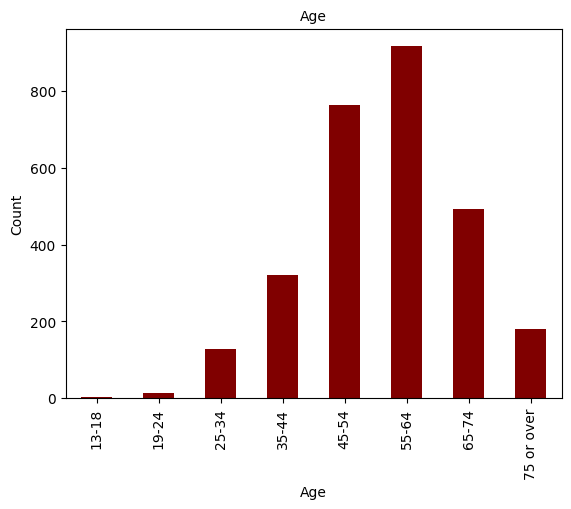

<Figure size 700x600 with 0 Axes>

In [ ]:
lisrat['Age'].value_counts().sort_index().plot(kind='bar', color='maroon')
plt.title("Age", fontsize = 10)
plt.xlabel("Age", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.figure(figsize=(7,6))

## Distribution of Useful Count

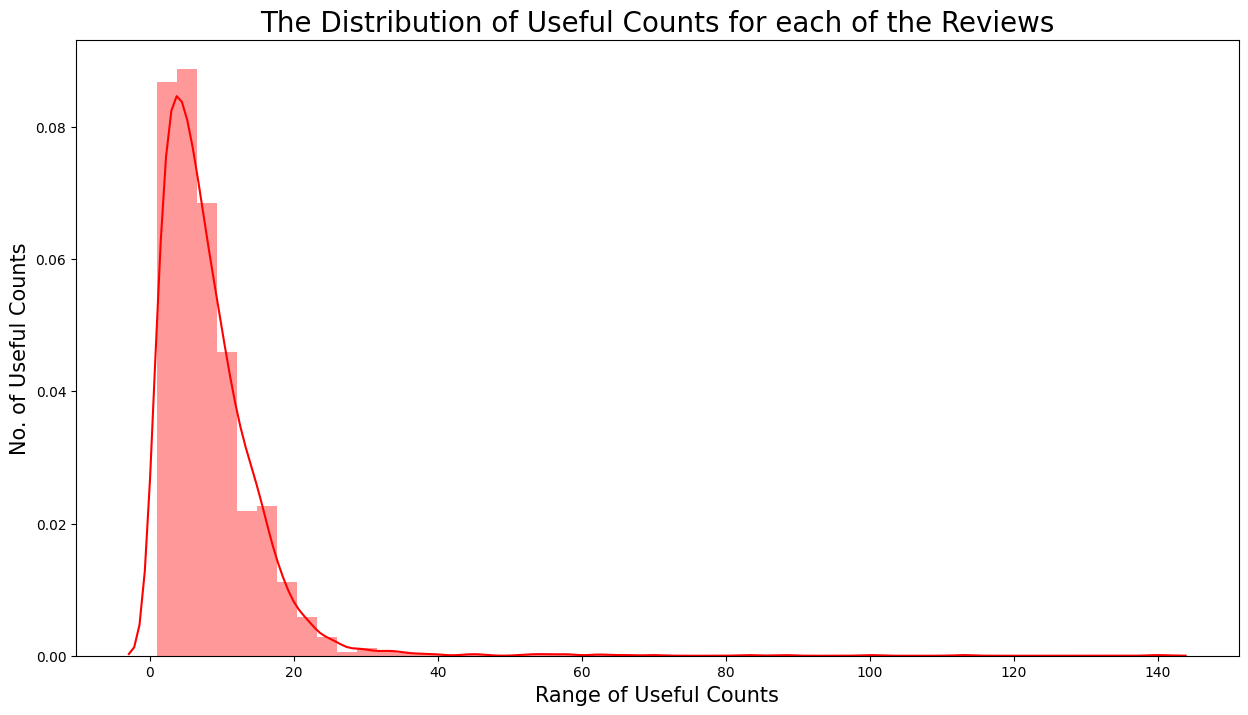

In [ ]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.distplot(lisi['UsefulCount'], color = 'red')
plt.title('The Distribution of Useful Counts for each of the Reviews', fontsize = 20)
plt.xlabel('Range of Useful Counts', fontsize = 15)
plt.ylabel('No. of Useful Counts', fontsize = 15)
plt.show()

## Reviews

In [ ]:
data = (dfc.groupby(["Age", "Satisfaction"])
          .agg({"Reviews": "count"})
          .reset_index()).sort_values(["Age", "Satisfaction"], ascending=True)

#data['Cumulative_Reviews'] = data.groupby(['Age'])['Reviews'].apply(lambda x: x.cumsum())

bars = (alt.Chart(data=data, title="Distribution of Reviews Over Age")
           .mark_bar(size=40,
                     strokeWidth=0.5,
                     stroke="white")
           .encode(x=alt.X('Age:O',
                           axis=alt.Axis(title="Age groups", grid=False)),
                   y=alt.Y('Reviews:Q', stack='zero',
                           scale=alt.Scale(type="linear"),
                           axis=alt.Axis(title="num of reviews")),
                   order=alt.Order('Satisfaction', sort='ascending'),
                   color=alt.Color("Satisfaction:Q",
                                   scale=alt.Scale(scheme="lightgreyteal",
                                                   bins=[0,1,2,3],
                                                   reverse=False))))
text = (alt.Chart(data=data[data["Reviews"] > 1500])
           .mark_text(align="center",
                      baseline="middle",
                      dx=0, dy=5)
           .encode(x=alt.X("Age:O"),
                   y=alt.Y("Reviews:Q", stack='zero'),
                   size = alt.SizeValue(9),
                   text="Reviews:Q",
                   color=alt.condition(alt.datum.Satisfaction > 1,
                                          alt.value("white"),
                                          alt.value("black"))))
chart = (alt.layer(bars, text)
            .configure(background="	#483D8B")
            .configure_title(font="Arial",
                             fontSize=18,
                             color="#e6f3ff",
                             dy=-10)
            .configure_text(color="white")
            .configure_legend(titleFontSize=12,
                              titleColor="white",
                              tickCount=10,
                              titleOpacity=0.8,
                              labelColor="white",
                              labelOpacity=0.7,
                              titlePadding=10)
            .configure_axis(titleFontSize=13,
                            titlePadding=20,
                            titleColor="white",
                            titleOpacity=0.8,
                            labelColor="white",
                            labelOpacity=0.7,
                            labelAngle=0,
                            tickOffset=0,
                            grid=True,
                            gridOpacity=0.15)
            .configure_view(strokeWidth=0)
            .properties(height=300, width=700)
)
chart

alt.LayerChart(...)

# **DATA PREPROCESSING SENTIMENT**

## Cleaning The Text

In [ ]:
dfsent = dfc.copy()

In [ ]:
def clean_text(text):
    return re.sub('[^a-zA-Z]', ' ', text).lower()
dfsent['cleaned_text'] = dfsent['Reviews'].apply(lambda x: clean_text(x))
dfsent['label'] = dfsent['Satisfaction'].map({1.0:0, 2.0:0, 3.0:1, 4.0:1, 5.0:1})

## Adding additional features - length of, and percentage of punctuations in the text

In [ ]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100
dfsent['Review_len'] = dfsent['Reviews'].apply(lambda x: len(x) - x.count(" "))
dfsent['punct'] = dfsent['Reviews'].apply(lambda x: count_punct(x))
dfsent.head()

,Age,Condition,Drug,DrugId,EaseofUse,Effectiveness,Satisfaction,Sex,Reviews,UsefulCount,Date,Year,Month,day_of_week,cleaned_text,label,Review_len,punct
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,5,Female,cleared me right up even with my throat hurtin...,1,1/13/2011,2011,1,Thursday,cleared me right up even with my throat hurtin...,1,71,0.0
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,1,Male,My grandfather was prescribed this medication ...,1,1/6/2009,2009,1,Tuesday,my grandfather was prescribed this medication ...,0,350,1.7
16,25-34,Birth Control,lyza,164750,1,1,1,Female,LYZA BIRTH CONTROL\nThese are the WORST birth ...,1,10/7/2017,2017,10,Saturday,lyza birth control these are the worst birth c...,0,394,4.8
18,25-34,Birth Control,lyza,164750,5,5,4,Female,I have been taking Lyza for two months now. I ...,1,1/30/2017,2017,1,Monday,i have been taking lyza for two months now i ...,1,288,3.5
19,25-34,Birth Control,lyza,164750,2,5,1,Female,I have been on this pill for a little over two...,3,6/1/2016,2016,6,Wednesday,i have been on this pill for a little over two...,0,302,3.3


## Tokenization

In [ ]:
def tokenize_text(text):
    tokenized_text = text.split()
    return tokenized_text
dfsent['tokens'] = dfsent['cleaned_text'].apply(lambda x: tokenize_text(x))
dfsent.head()

,Age,Condition,Drug,DrugId,EaseofUse,Effectiveness,Satisfaction,Sex,Reviews,UsefulCount,Date,Year,Month,day_of_week,cleaned_text,label,Review_len,punct,tokens
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,5,Female,cleared me right up even with my throat hurtin...,1,1/13/2011,2011,1,Thursday,cleared me right up even with my throat hurtin...,1,71,0.0,"[cleared, me, right, up, even, with, my, throa..."
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,1,Male,My grandfather was prescribed this medication ...,1,1/6/2009,2009,1,Tuesday,my grandfather was prescribed this medication ...,0,350,1.7,"[my, grandfather, was, prescribed, this, medic..."
16,25-34,Birth Control,lyza,164750,1,1,1,Female,LYZA BIRTH CONTROL\nThese are the WORST birth ...,1,10/7/2017,2017,10,Saturday,lyza birth control these are the worst birth c...,0,394,4.8,"[lyza, birth, control, these, are, the, worst,..."
18,25-34,Birth Control,lyza,164750,5,5,4,Female,I have been taking Lyza for two months now. I ...,1,1/30/2017,2017,1,Monday,i have been taking lyza for two months now i ...,1,288,3.5,"[i, have, been, taking, lyza, for, two, months..."
19,25-34,Birth Control,lyza,164750,2,5,1,Female,I have been on this pill for a little over two...,3,6/1/2016,2016,6,Wednesday,i have been on this pill for a little over two...,0,302,3.3,"[i, have, been, on, this, pill, for, a, little..."


## Lemmatization and Removing Stopwords

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
def lemmatize_text(token_list):
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if not token in set(all_stopwords)])

lemmatizer = nltk.stem.WordNetLemmatizer()
dfsent['lemmatized_review'] = dfsent['tokens'].apply(lambda x: lemmatize_text(x))
dfsent.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Age,Condition,Drug,DrugId,EaseofUse,Effectiveness,Satisfaction,Sex,Reviews,UsefulCount,Date,Year,Month,day_of_week,cleaned_text,label,Review_len,punct,tokens,lemmatized_review
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,5,Female,cleared me right up even with my throat hurtin...,1,1/13/2011,2011,1,Thursday,cleared me right up even with my throat hurtin...,1,71,0.0,"[cleared, me, right, up, even, with, my, throa...",cleared right even throat hurting went away ta...
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,1,Male,My grandfather was prescribed this medication ...,1,1/6/2009,2009,1,Tuesday,my grandfather was prescribed this medication ...,0,350,1.7,"[my, grandfather, was, prescribed, this, medic...",grandfather prescribed medication coumadin ass...
16,25-34,Birth Control,lyza,164750,1,1,1,Female,LYZA BIRTH CONTROL\nThese are the WORST birth ...,1,10/7/2017,2017,10,Saturday,lyza birth control these are the worst birth c...,0,394,4.8,"[lyza, birth, control, these, are, the, worst,...",lyza birth control worst birth control pill ev...
18,25-34,Birth Control,lyza,164750,5,5,4,Female,I have been taking Lyza for two months now. I ...,1,1/30/2017,2017,1,Monday,i have been taking lyza for two months now i ...,1,288,3.5,"[i, have, been, taking, lyza, for, two, months...",taking lyza two month anxious going back pill ...
19,25-34,Birth Control,lyza,164750,2,5,1,Female,I have been on this pill for a little over two...,3,6/1/2016,2016,6,Wednesday,i have been on this pill for a little over two...,0,302,3.3,"[i, have, been, on, this, pill, for, a, little...",pill little two month experience horrible know...


# **EDA SENTIMENT**

In [ ]:
# Missing values in the dataset
print(f"Number of null in label: { dfsent['Satisfaction'].isnull().sum() }")
print(f"Number of null in text: { dfsent['Reviews'].isnull().sum()}")


Number of null in label: 0
Number of null in text: 0


## **Visualizing Word Clouds**

In [ ]:
df_negative = dfsent[ (dfsent['Satisfaction']==1.0)
| (dfsent['Satisfaction']==2.0)]

df_positive = dfsent[ (dfsent['Satisfaction']==3.0)
| (dfsent['Satisfaction']==4.0) | (dfsent['Satisfaction']==5.0)]

#convert to list
negative_list= df_negative['lemmatized_review'].tolist()
positive_list= df_positive['lemmatized_review'].tolist()

filtered_negative = ("").join(str(negative_list))
#convert the list into a string of spam
filtered_negative = filtered_negative.lower()

filtered_positive = ("").join(str(positive_list))
#convert the list into a string of ham
filtered_positive = filtered_positive.lower()

## Positive Reviews

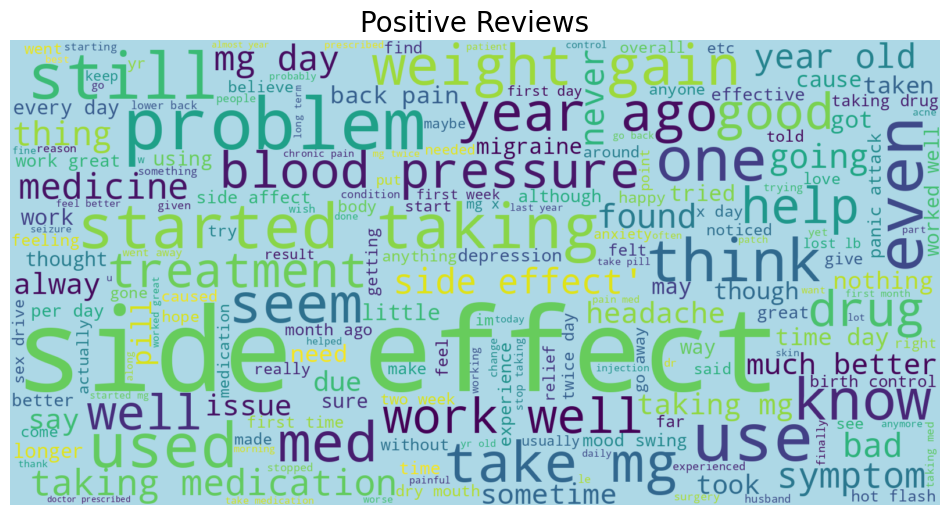

In [ ]:

wordcloud = WordCloud(background_color='lightblue',
                      width=1600, height=800,
                      max_font_size=200).generate(filtered_positive)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Positive Reviews', fontsize = 20)
plt.axis("off")
plt.show()

## Negative Reviews

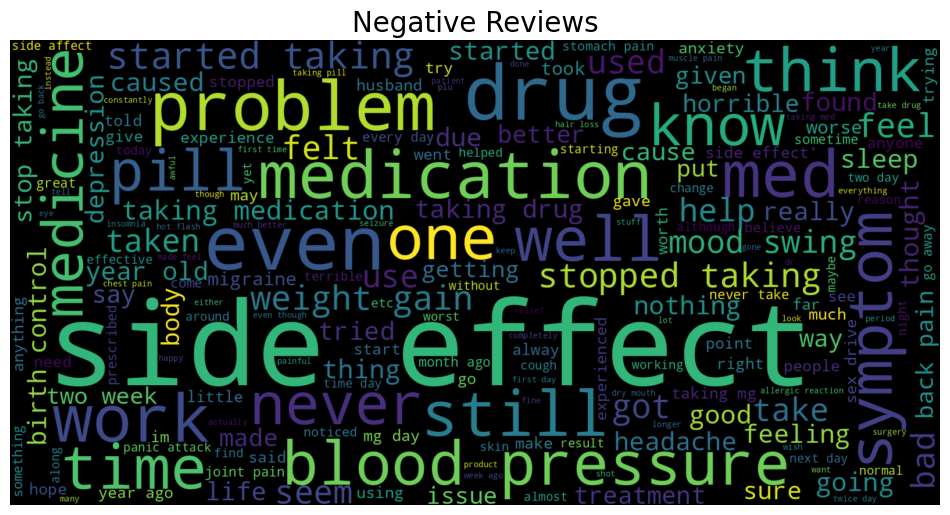

In [ ]:
wordcloud = WordCloud(width=1600, height=800,
                      max_font_size=200).generate(filtered_negative)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Negative Reviews', fontsize = 20)
plt.axis("off")
plt.show()

# **FEATURE EXTRACTION FROM TEXT**

In [ ]:
X = dfsent[['lemmatized_review', 'Review_len', 'punct']]
y = dfsent['label']
print(X.shape)
print(y.shape)


(233780, 3)
(233780,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(163646, 3)
(70134, 3)
(163646,)
(70134,)


### Vectorizer TF IDF

In [ ]:
tfidf = TfidfVectorizer(max_df = 0.5, min_df = 2)

# ignore terms that occur in more than 50% documents and the ones that occur in less than 2
tfidf_train = tfidf.fit_transform(X_train['lemmatized_review'])
tfidf_test = tfidf.transform(X_test['lemmatized_review'])

X_train_vect = pd.concat([X_train[['Review_len',
                                   'punct']].reset_index(drop=True),
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['Review_len',
                                 'punct']].reset_index(drop=True),
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()